In [74]:
import os
import site
import random
import pandas as pd 
import numpy as np
from glob import glob
from os.path import join
from tqdm.auto import tqdm

site.addsitedir('../include')
from visualize import plot_action_list
from utils import get_labels_start_end_time


In [72]:
## Load features and ground truth paths
features_dir = '/home/simon/Data/ieee_cataracts/features/rgb/'
videos_dir = '/home/simon/Data/ieee_cataracts/videos_ds/'
raw_gt_dir = '/home/simon/Data/ieee_cataracts/ground_truth/'
processed_gt_dir = '/home/simon/Data/ieee_cataracts/processed_groundTruth/'
os.makedirs(processed_gt_dir, exist_ok=True)

features = os.listdir(features_dir)
raw_gt_files = [file for path, _, _ in os.walk(raw_gt_dir) for file in glob(join(path, "*.csv"))]

## Translate raw ground_truth to MS-TCN++ ground_truth format
- Calculate downsampling rate for 29 fps to 15 fps per file
- Mapping integer steps to labels 
- save to file in processed_gt_dir

In [73]:
def get_corresponding_gt(feat_path, gt_files):
    feat_name = feat_path.split('_')[0]
    
    for gt in gt_files:
        if feat_name in gt:
            ground_truth = pd.read_csv(gt)
            return ground_truth
    print(f"Could not find ground truth for {feat_path}")
    return None

## Process ground truth
labels = ['background', 'toric_marking', 'implant_ejection', 'incision', 'viscodilatation', 'capsulorhexis', 'hydrodissetion', 
          'nucleus_breaking', 'phacoemulsification', 'vitrectomy', 'irrigation_aspiration', 'preparing_implant', 'manual_aspiration', 
          'implantation', 'positioning', 'ovd_aspiration', 'suturing', 'sealing_control', 'wound_hydratation']

for path in tqdm(features):
    feat = np.load(join(features_dir, path))
    raw_gt = get_corresponding_gt(path, raw_gt_files)
    frames_to_label = {}
    
    downsampling_factor = feat.shape[0] / len(raw_gt)
    
    # Downsample ground_truth and save to dict
    for row in raw_gt.itertuples(index=False):
        frame = round(row.Frame * downsampling_factor)
        frames_to_label[frame] = labels[row.Steps]
        
    # Write dict to disc
    out_file = join(processed_gt_dir, path.split('_')[0] + '.txt')
    open(out_file, 'w').write("\n".join(frames_to_label.values()))
    

  0%|          | 0/50 [00:00<?, ?it/s]

## Remove background between classes
- Code taken from SICS preprocessing

In [76]:
def remove_intraclass_bg(actions, idx_end=-1, bg='background'):
    last_action = None 
    for i, action in enumerate(actions):
        if i >= idx_end: # skip last section
            continue
        if last_action == None and action != bg:
            last_action = action
        elif action == bg and last_action != None:
            actions[i] = last_action
        elif action != last_action and action != bg:
            last_action = action
    return actions

output_dir = processed_gt_dir[:-1] + '_nobg/'
os.makedirs(output_dir, exist_ok=True)
gt_files = os.listdir(processed_gt_dir)
for file in tqdm(gt_files):
    cur_gt = open(join(processed_gt_dir, file), 'r').read().split('\n') # Read file
    
    _, start, _ = get_labels_start_end_time(cur_gt)
    cur_gt = remove_intraclass_bg(cur_gt, idx_end=start[-1], bg='background') 
    
    open(join(output_dir, file), 'w').write("\n".join(cur_gt)) # Write changed file


  0%|          | 0/50 [00:00<?, ?it/s]

## Write mapping to file
- Write integer (0-18) to string label (e.g. background, incision, ...) mapping to file

In [71]:

mapping_path = "/home/simon/Data/ieee_cataracts/mapping.txt"
for i, label in enumerate(labels):
    open(mapping_path, 'a').write(f"{i} {label}\n")
# print(open(mapping_path, 'r').read())

## Sanity check
- Various sanity checks for this data

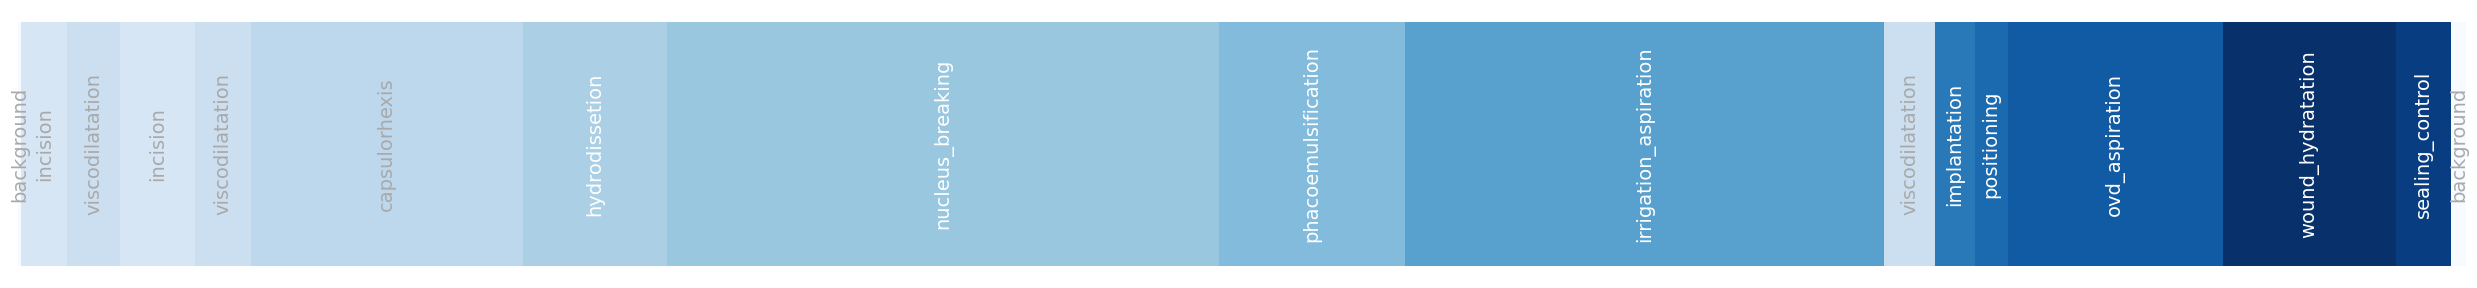

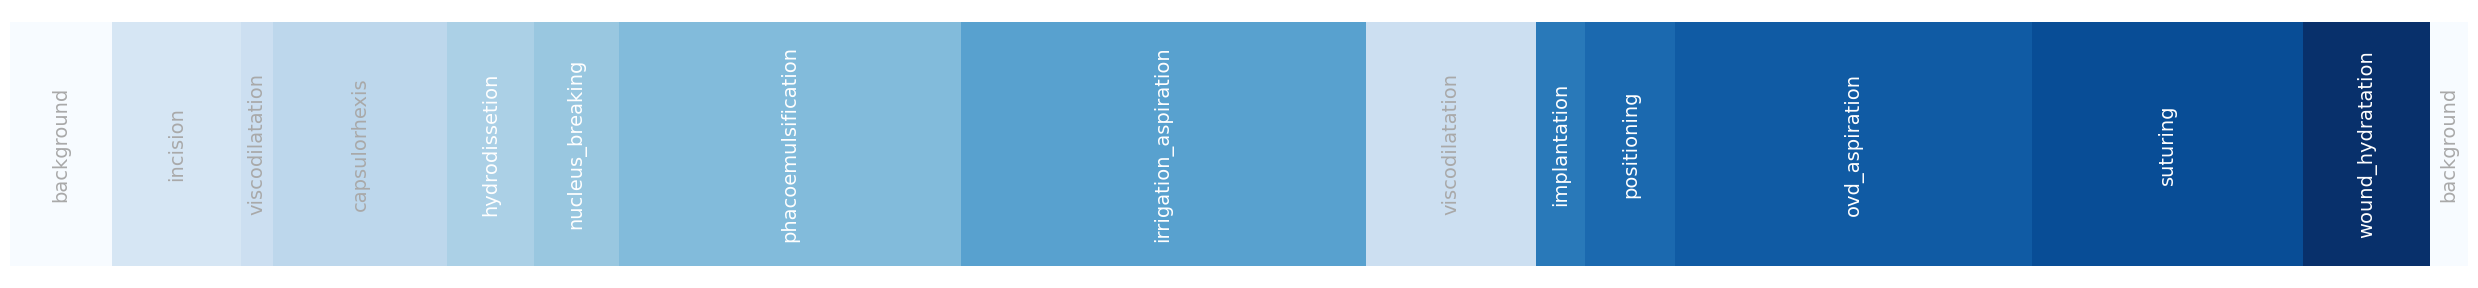

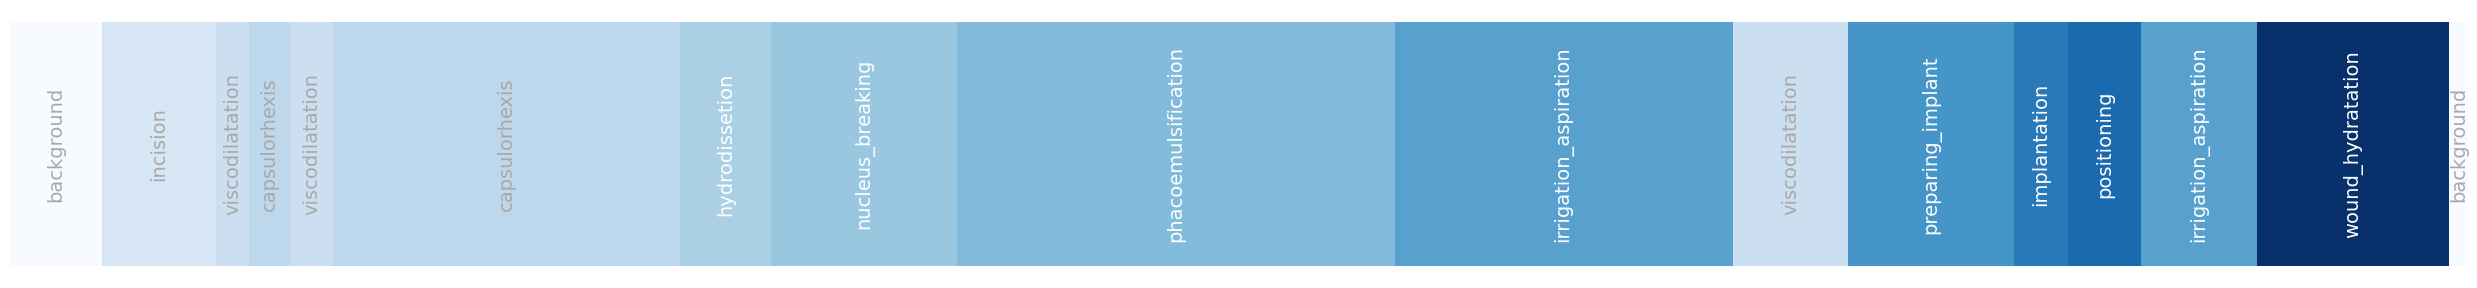

In [80]:
pp_ground_truth = os.listdir(output_dir)

# Plot the first 5 ground truth files
for file in random.sample(pp_ground_truth, 3): 
    cur_gt = open(join(output_dir, file), 'r').read().split('\n')
    #print(list(set(cur_gt)), cur_gt[-1])
    #print(cur_gt[-10:])
    plot_action_list(cur_gt, labels)